In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
usage_df = pd.read_csv('oc_c.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
0,90620,Orange County,1,2015,Residential,6974967.0,6.974967
1,90620,Orange County,1,2015,Commercial,8772105.0,8.772105
2,90621,Orange County,1,2015,Residential,4897033.0,4.897033
3,90621,Orange County,1,2015,Commercial,6312373.0,6.312373
4,90623,Orange County,1,2015,Residential,2847987.0,2.847987


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18731 entries, 0 to 18730
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ZipCode        18731 non-null  int64  
 1   County         18731 non-null  object 
 2   Month          18731 non-null  int64  
 3   Year           18731 non-null  int64  
 4   CustomerClass  18731 non-null  object 
 5   TotalkWh       18731 non-null  float64
 6   TotalGWh       18731 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 1.0+ MB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18731 entries, 0 to 18730
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ZipCode        18731 non-null  int64         
 1   County         18731 non-null  object        
 2   Month          18731 non-null  int64         
 3   Year           18731 non-null  int64         
 4   CustomerClass  18731 non-null  object        
 5   TotalkWh       18731 non-null  float64       
 6   TotalGWh       18731 non-null  float64       
 7   Date           18731 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.1+ MB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,90620,Orange County,1,2015,Residential,6974967.0,6.974967
2015-01-01,90620,Orange County,1,2015,Commercial,8772105.0,8.772105
2015-01-01,90621,Orange County,1,2015,Residential,4897033.0,4.897033
2015-01-01,90621,Orange County,1,2015,Commercial,6312373.0,6.312373
2015-01-01,90623,Orange County,1,2015,Residential,2847987.0,2.847987


## Resampling dataframe to total monthly usage

In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,1.180342e+09,1180.342333
2015-02-28,1.203836e+09,1203.835756
2015-03-31,1.180950e+09,1180.949656
2015-04-30,1.213340e+09,1213.340260
2015-05-31,1.208142e+09,1208.141684


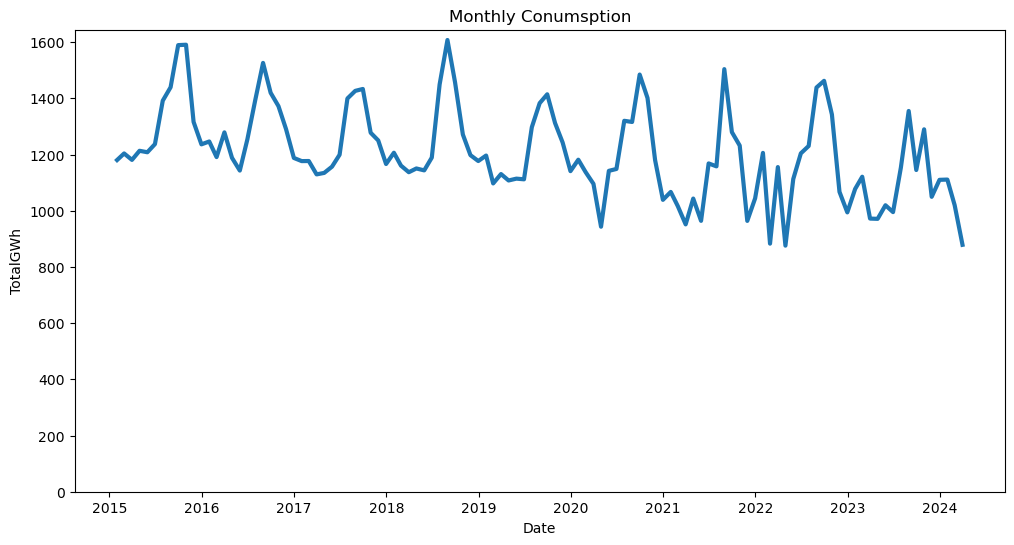

In [13]:
# PLotting data
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], linewidth=3)
plt.title("Monthly Conumsption")
plt.xlabel("Date")
plt.ylabel("TotalGWh")
plt.ylim(ymin=0)
plt.show()

## Implementing SARIMA model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Checking for stationarity of data

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(usage['TotalGWh'])

ADF Statistic: -0.41334282284877055
p-value: 0.907847054423276
Non-Stationary


***SARIMAX model can still handle non-stationary data***

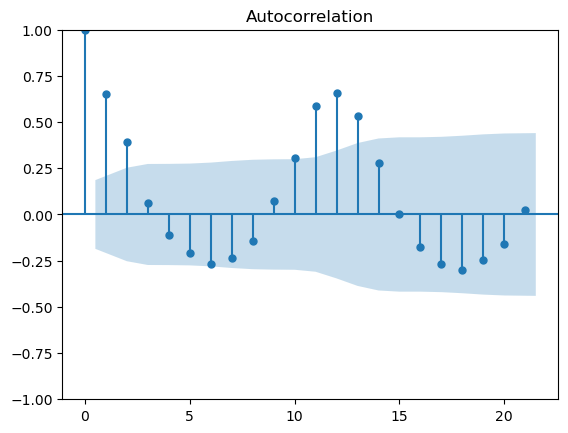

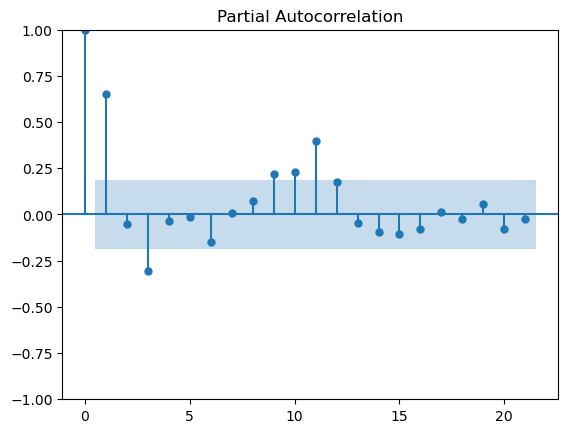

In [16]:
 # Plot ACF and PACF
plot_acf(usage['TotalGWh'])
plot_pacf(usage['TotalGWh'])
plt.show()

## Using AutoArima to find the parameters for SARIMAX model

In [17]:
# Install the library if necessary
# !pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(usage['TotalGWh'],
                   test='adf',
                   seasonal=True,
                   #max_p=3, max_q=3,
                   start_p=0,
                   d=1,
                   trace=True,
                   start_P=0,
                   m=12,
                   D=None,
                   stepwise=True,
                   with_intercept=True,
                   suppress_warnings=True)

model.fit(usage['TotalGWh'])

# Check the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=1376.431, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1384.231, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1355.561, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1374.595, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1382.282, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1384.777, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1339.322, Time=0.40 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1331.447, Time=0.82 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1330.227, Time=0.41 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1373.172, Time=0.16 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1331.476, Time=1.10 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1359.745, Time=0.49 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1359.395, Time=0.36 sec
 ARIMA(2,1,0)(1,0,1)[12]

In [18]:
# p, d, q parameters
model.order

(2, 1, 0)

In [19]:
# P, D, Q, s parameters
model.seasonal_order

(1, 0, 1, 12)

In [20]:
# Define SARIMA parameters from AutoArima results

# Fit the SARIMA model
model = SARIMAX(usage['TotalGWh'], order=model.order, seasonal_order=model.seasonal_order)
results = model.fit()
model

### Forecasting the next 12 months

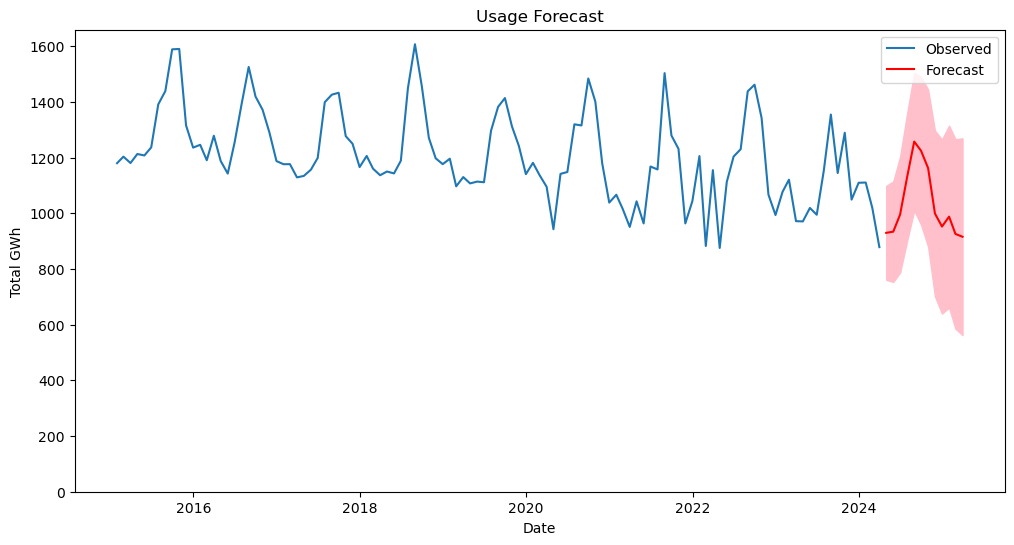

In [21]:
# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

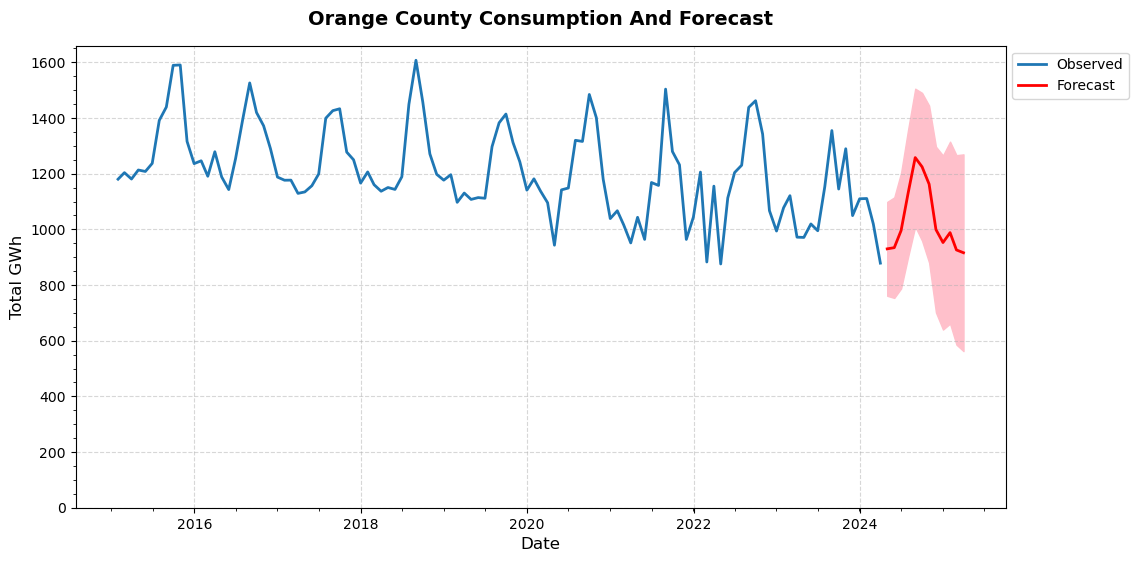

In [22]:
# Alternative Plot
from matplotlib.ticker import AutoMinorLocator


# Plot settings
plt.figure(figsize=(12, 6))
ax1 = sns.lineplot(data=usage['TotalGWh'], label='Observed',linewidth=2)
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='red', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')


# Plot labels and legend
plt.title("Orange County Consumption And Forecast", weight='bold', fontsize=14, pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(ymin=0)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.14,1),loc='upper right')

# Show plot
plt.show()

### Evaluate Model

In [23]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 76.18650952252409
MSE: 7815.855283385103
RMSE: 88.40732595992881


In [24]:
observed

Date
2023-04-30     971.132490
2023-05-31    1019.519587
2023-06-30     995.140814
2023-07-31    1153.506826
2023-08-31    1355.041955
2023-09-30    1144.991935
2023-10-31    1289.702930
2023-11-30    1049.532057
2023-12-31    1109.989013
2024-01-31    1110.920553
2024-02-29    1019.565911
2024-03-31     878.710056
Freq: M, Name: TotalGWh, dtype: float64

In [25]:
forecast_mean

2024-04-30     930.060373
2024-05-31     934.347575
2024-06-30     995.831079
2024-07-31    1131.029128
2024-08-31    1257.998521
2024-09-30    1224.932728
2024-10-31    1162.579769
2024-11-30     999.351363
2024-12-31     952.767423
2025-01-31     988.363908
2025-02-28     926.175514
2025-03-31     916.079365
Freq: M, Name: predicted_mean, dtype: float64

### Forecasting the next 24 months

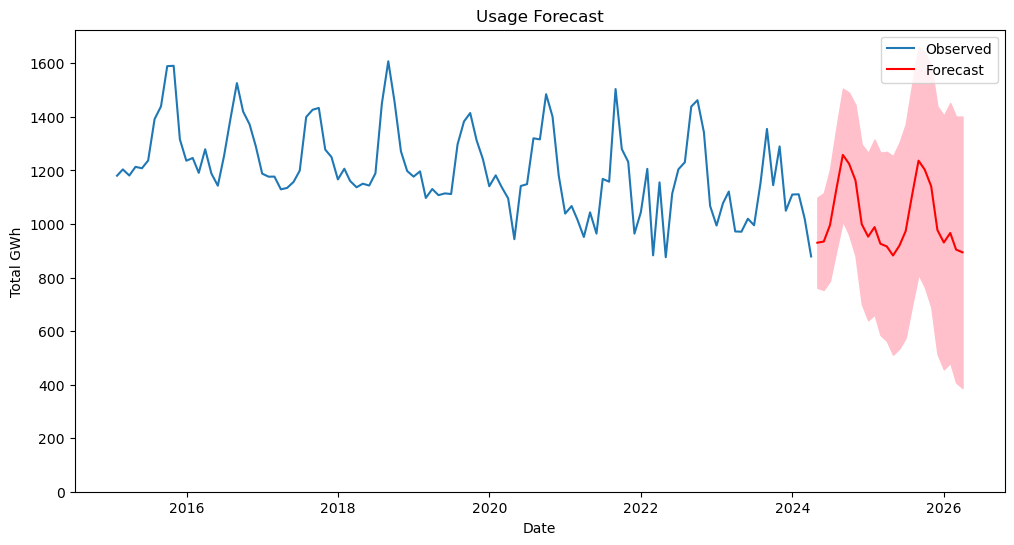

In [26]:
# Forecast future demand
forecast_periods = 24  # Forecast the next 24 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

### Evaluate Model

In [27]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 112.30285098203883
MSE: 16520.86659930839
RMSE: 128.53352325097288


In [28]:
observed

Date
2022-04-30     875.769823
2022-05-31    1112.858785
2022-06-30    1204.189355
2022-07-31    1230.517399
2022-08-31    1438.538862
2022-09-30    1462.294928
2022-10-31    1342.462977
2022-11-30    1067.186050
2022-12-31     994.127149
2023-01-31    1077.633198
2023-02-28    1121.018736
2023-03-31     972.076743
2023-04-30     971.132490
2023-05-31    1019.519587
2023-06-30     995.140814
2023-07-31    1153.506826
2023-08-31    1355.041955
2023-09-30    1144.991935
2023-10-31    1289.702930
2023-11-30    1049.532057
2023-12-31    1109.989013
2024-01-31    1110.920553
2024-02-29    1019.565911
2024-03-31     878.710056
Freq: M, Name: TotalGWh, dtype: float64

In [29]:
forecast_mean

2024-04-30     930.060373
2024-05-31     934.347575
2024-06-30     995.831079
2024-07-31    1131.029128
2024-08-31    1257.998521
2024-09-30    1224.932728
2024-10-31    1162.579769
2024-11-30     999.351363
2024-12-31     952.767423
2025-01-31     988.363908
2025-02-28     926.175514
2025-03-31     916.079365
2025-04-30     882.364691
2025-05-31     919.459799
2025-06-30     973.466562
2025-07-31    1108.258356
2025-08-31    1236.500193
2025-09-30    1202.679272
2025-10-31    1140.630856
2025-11-30     977.425762
2025-12-31     930.855586
2026-01-31     966.448436
2026-02-28     904.282515
2026-03-31     894.193403
Freq: M, Name: predicted_mean, dtype: float64

In [30]:
customer_consum = usage_df.groupby('CustomerClass')['TotalGWh'].sum()
customer_consum

CustomerClass
Agricultural     1864.124149
Commercial      54623.831638
Industrial      29950.691909
Residential     47486.224233
Name: TotalGWh, dtype: float64

In [31]:
customer_df = customer_consum.reset_index()
customer_df

,CustomerClass,TotalGWh
0,Agricultural,1864.124149
1,Commercial,54623.831638
2,Industrial,29950.691909
3,Residential,47486.224233


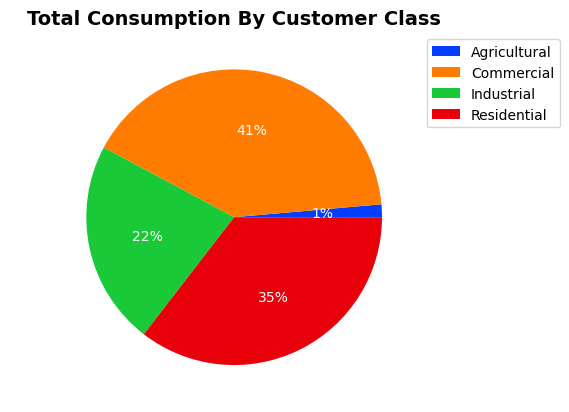

In [32]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='w'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

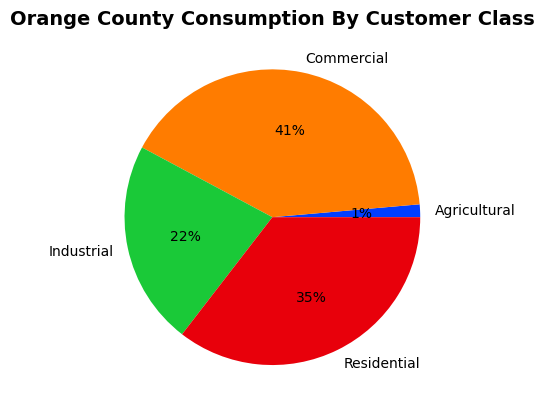

In [33]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='black'))
plt.title('Orange County Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
#plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

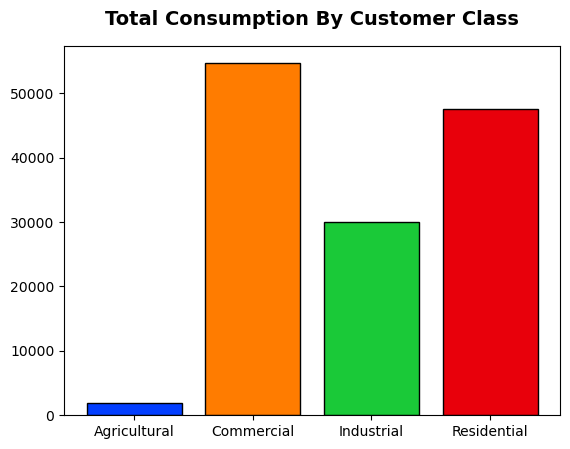

In [34]:
# Bar chart
plt.bar(customer_df['CustomerClass'],customer_df['TotalGWh'], color=palette_color,edgecolor='black', )
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center', pad=15)
plt.show()